# Reprojecting GOES JPG Images to Mercator and Lambert Conformal Conic in Python with Cartopy
**Lance Berc**

2019-12-03

## Synopsis
Imagery from NASA/NOAA weather satellites is readily available from many sources but the raw data is more useful when reprojected from the satellite's viewpoint to a more familiar map projection centering on a specific area of interest.

The Mercator projection is used because (a) it's what we're used to from ship's navagational charts and grammar school wall maps and (b) it allows overlaying weather charts available from NOAA's Ocean Prediction Center. Lambert Conformal Conic (LCC) is also showen because it's used by US aeronautical charts and some NOAA weather models like the NAM and HRRR (among many places).

Georeferencing parameters (for mapping the image to Earth coordinates) are derived from data published by NASA. Much scientific satellite imagery comes in GeoTIFF or NetCDF format containing this information but it isn't present in our simple JPG and PNG images.

This code handles GOES Full Disk and CONUS sectors. GOES satellites in Mode 6 (the current operational mode) can also produce images for two mesoscale regions. The same reprojection principles apply to these regions if one knows the scan angle to the image's upper-left corner.

### `matplotlib` + `cartopy`
`matplotlib` is a Python library for 2-D plotting that is oriented towards generating beautiful images on paper. `cartopy` adds the ability to put cartographic-oriented data into the plots. `matplotlib`'s flexibility and array of plugins makes it popular for a variety of datatypes and use cases.

#### Nota Bene
Although `cartopy` uses `proj` it doesn't seem to be a deep integration - `cartopy` reimplements several projections and I'm not sure if it can be extended to others with only proj description strings.

In theory one can use the `matplotlib.pyplot.imshow()` function to perform the Geos projection conversion, but `imshow` doesn't work with non-uniform data (Geos pixels cover more area at the edges than center) so we have to use the more capable `pcolormesh()`. This is more complex in both time and space; a CONUS (5000x3000) reprojection with GDAL takes about one second and uses less than 500MB RAM; with cartopy/matplotlib the same operation takes 37 seconds and uses several GB of RAM. Here is [a similar implementation using GDAL](GOES_GDAL.ipynb).

This implementation was inspired by Brian Blaylock's code, https://github.com/blaylockbk/pyBKB_v3. He has many examples of Cartopy and other tools manipulating Meteorological data with Python. Brian, thank you for sharing!

## References
NASA's GOES Product Users Guide. Projection is defined in section 5.1.2.7.

https://www.goes-r.gov/users/docs/PUG-L1b-vol3.pdf

Meteosat projection is defined in section 4.4.3.2 of

https://www.cgms-info.org/documents/cgms-lrit-hrit-global-specification-(v2-8-of-30-oct-2013).pdf

https://www.cgms-info.org/documents/pdf_cgmf_03.pdf (older version)

#### Additional Python Packages and Libraries
https://numpy.org - Very slick base array handling

https://proj.org/ - Projections and conversions

https://matplotlib.org - From John Hunter - interesting backstory

https://scitools.org.uk/cartopy/docs/latest/ - Started by the UK Met Office

Getting versions of the packages that work together can be an issue. One solution is to use [Anaconda](https://www.anaconda.com/distribution/) + virtual environments. For MacOS I used the [GDAL complete bundle from KyngChaos](http://www.kyngchaos.com/software/frameworks) which contains compatible versions of GDAL, GEOS, and Proj. My Windows7 environment isn't so clean - YMMV.

#### Background

NASA and EUMETSAT publish great reference material; it can be a bit dense:

https://www.goes-r.gov/resources/docs.html

https://www.eumetsat.int/website/home/Data/TechnicalDocuments/index.html

## Example 1 - GOES-17 CONUS (PACUS) to Mercator

In [1]:
%matplotlib inline
import numpy as np
import pyproj
import matplotlib
import matplotlib.pyplot
import cartopy
import cartopy.crs

We're going to reproject a GOES-17 CONUS (5000x3000) JPEG image. These are sometimes called PACUS images since they have more ocean than land. They're useful for analyzing weather before it reaches the US mainland.

### Raw GOES-17 CONUS (PACUS) Image
![raw_GOES-17_image](./GOES-17_CONUS.jpg)

Orbit and perspective definitions for GOES satellites from NASA's Product Users Guide. The per-resolution items contain the scan angle, raster size, and positioning of the upper-left corner. "1k" and "2k" represent the per-pixel resolutions of the images. There are both higher- (".5k") and lower ("4k" and "10k") resolutions defined for various instruments.

The nanPoint is a valid spot on the globe that invalid locations will get mapped to - otherwise pcolormesh fails. This method only works if one corner of the source is off-earth; some other heuristic is needed for full-disk images that have all four corners in space.

In [2]:
sourcefn = "GOES-17_CONUS.jpg"
destfn = "test.jpg"
# Set the output image to cover the Western US and Pacific weather approches
# [min_lon, max_lon, min_lat, max_lat]
output_extent = [-160.0, -111.1, 33.0, 50.1]

goes17 = { # GOES-17, aka GOES-S, GOES-WEST
    "perspective_height": 35786023.0,
    "height": 42164160.0,
    "longitude": -137.0,
    "sweep_axis": 'x',
    "semi_major": 6378137.0,
    "semi_minor": 6356752.31414,
    "flattening": 298.257222096,
    "eccentricity": 0.0818191910435,
    "1k": {
        "resolution": 0.000028,
        "FD": {
            "x_offset": -0.151858,
            "y_offset":  0.151858,
            "shape": (10848, 10848),
            "nanPoint": None          # Need to figure out how to handle off-earth for FD images
        },
        "CONUS": {
            "x_offset": -0.069986,
            "y_offset":  0.128226,
            "shape": (5000, 3000),
            "nanPoint": None          # GOES-17 PACUS is entirely on-earth
        }
    }
}

This is a GOES-17 1k-resolution image of the CONUS sector. Set up the Geostationary projection with its parameters. Also create the Mercator (output) projection and the Plate Caree projection which will be used to translate some coordinates.

In [3]:
s = goes17
res = s['1k']
sector = res['CONUS']
width, height = sector["shape"]
dpi = 100

# Cartopy projections
mercator = cartopy.crs.Mercator()
# We need Plate-Carree to define extent because Cartopy isn't complete and can't do inverse mapping w/ Mercator
platecarree = cartopy.crs.PlateCarree()
geostationary = cartopy.crs.Geostationary(central_longitude=s["longitude"],
                                          satellite_height=s["perspective_height"],
                                          sweep_axis=s["sweep_axis"])

Build an array of the lon, lat for each projected point. This is done starting with a vector of X and Y locations in Geostationary space which get converted to lon/lat by `Proj`. The find the off-earth points and map them to an on-earth location .

In [4]:
# Projection coords are scan angle * satellite height over ellipsoid (not center of earth)
resolution = res['resolution']
x_off = sector["x_offset"]
y_off = sector["y_offset"]
p_height = s["perspective_height"]
nanPoint = sector['nanPoint']

# Compute x & y coordinates for each raster pixel in Geos (projection) space
x = np.ndarray(shape=(width))
for i in range(width):
    x[i] = (x_off + (i*resolution)) * p_height
y = np.ndarray(shape=(height))
for i in range(height):
    y[i] = (y_off - (i*resolution)) * p_height
X, Y = np.meshgrid(x, y) # Mesh the x- and y-vectors together

# Convert from projection coords to lon/lat
p = pyproj.Proj(proj='geos', h=s["perspective_height"], lon_0=s["longitude"], sweep=s["sweep_axis"])
lons, lats = p(X, Y, inverse=True)

# Map the upper corner off-earth points to somewhere on-earth.
# This heuristic works only for images with one off-earth corner.
# Full Disk images need something else - maybe remap by quadrant?
if nanPoint != None:
    x0, y0 = nanPoint
    lats[lats == 1e30] = x0
    lons[lons == 1e30] = y0

Set up matplotlib to have no borders or decorations and have the image fill the figure.

Read the image into matplotlib. Then delete the last column (don't know why) and reshape it to the form pcolormesh needs. This array will be the colorTuple used to paint the canvas.

A post on Stack Overflow suggested adding an alpha-channel to speed up the reprojection (maybe it makes pixels 32-bit aligned) but I didn't see a significant difference.

Set the figure's output area using Plate Carree as the Coordinate Reference System for the X and Y extents.

Call `pcolormesh` using a dummy array the same shape as the colorTuple. `AFAIK` pcolormesh paints each output pixel interpolating from its neighbors in the source colorTuple. There is another magic call, this time to `set_array(None)` 

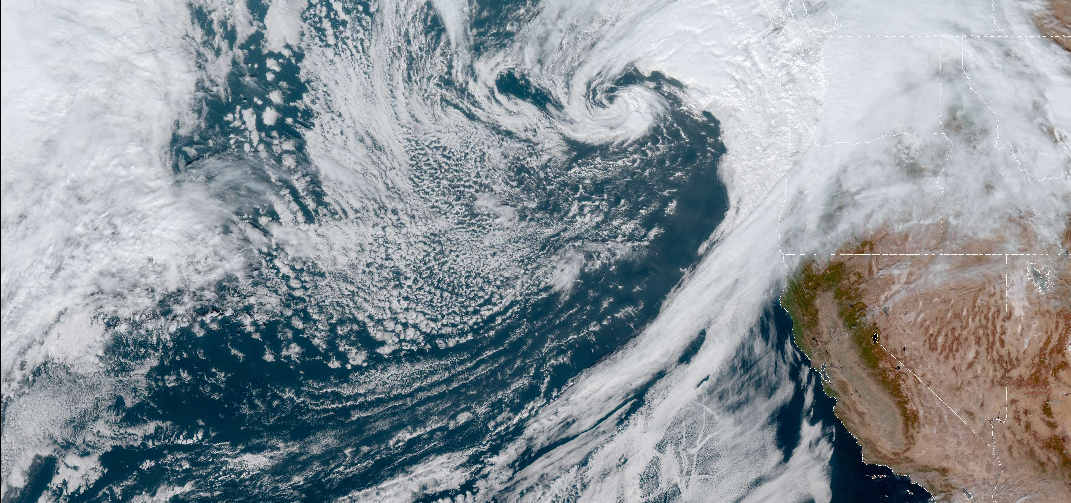

In [5]:
# The goal is a 16:9 jpg file with no matplotlib decoration that is sized w/dpi
# This gets sort of close
w, h = (1920/dpi, 1280/dpi)

matplotlib.rcParams['savefig.pad_inches'] = 0
matplotlib.rcParams['savefig.bbox'] = "tight"

fig = matplotlib.pyplot.figure(frameon=False) # Setting size here doesn't work right
fig.set_size_inches(w, h)
ax = matplotlib.pyplot.axes(projection=mercator, frameon=False)
ax.axis('off')
ax.set(xlim=[0, w], ylim=[h, 0], aspect=1) # Square pixels (and they are at nadir)

mpimg = matplotlib.pyplot.imread(sourcefn)
rgb = mpimg[:,:-1,:] * (1.0/255.0) # Normalize from RGB(0-255) to (0-1)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # Flatten the array for pcolormesh
#colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

ax.set_extent(output_extent, crs=cartopy.crs.PlateCarree())
# Create a dummy array w/ data in the proper shape - pcolormesh will use colorTuple for values
dummy_array = np.empty([height, width])
newimg = ax.pcolormesh(lons, lats, dummy_array, color=colorTuple, linewidth=0, transform=platecarree)
newimg.set_array(None) # Without this line the RGB colorTuple is ignored and only dummy is plotted.

matplotlib.pyplot.show()

And there you have it, California looking more like we're used to.

`matplotlib` + `cartopy` is a memory pig. Remember to close the figure.

In [6]:
#matplotlib.pyplot.savefig(destfn)
matplotlib.pyplot.close(fig) # release memory!

## Example 2 - GOES-16 CONUS to Lambert Conformal Conic
Lambert Conformal Conic is a projection that is good for rectangular regions like the United States and France (it's pretty cool - projecting onto [a cone that slices into the earth](https://en.wikipedia.org/wiki/Lambert_conformal_conic_projection) along two parallel lines). It's the standard for US aeronautical charts and several NOAA weather models.

GOES-16 (aka GOES-East) is the main weather imager for the US, bit it's on the east side of the country (centered at 75 West) and the upper left corner of its CONUS image is off the earth. We remap these off-earth points to a location in the Gulf of Alaska (as suggested by Brian Blaylock) which is why the upper left of the resulting image is so distorted. This isn't a big problem in practice - use GOES-17 for excellent, less-distorted coverage of the Western United States.

### Raw GOES-16 CONUS Image
Notice how the upper left corner is off-earth (the black part). That means the input raster points don't map to a lon/lat which can cause issues for cartopy.
![raw_GOES-16_CONUS_image](GOES-16_CONUS.jpg)

Definitions are similar to the example above, but for GOES-16.

In [7]:
sourcefn = "GOES-16_CONUS.jpg"
destfn = "cartopy_lcc.jpg"

# A box around the continental United States
# [min_lon, max_lon, min_lat, max_lat]
output_extent = [-130.0, -60.0, 24.5, 51.0]

goes16 = { # GOES-16, aka GOES-R, GOES-EAST
    "perspective_height": 35786023.0, # from the ellipsoid
    "height": 42164160.0,             # from center of the earth
    "longitude": -75.0,
    "sweep_axis": 'x',
    "semi_major": 6378137.0,          # GRS-80 ellipsoid
    "semi_minor": 6356752.31414,      # GRS-80 ellipsoid
    "flattening": 298.257222096,
    "eccentricity": 0.0818191910435,
    # The other resolution (.5k, 2k, 4k, etc) can be added here
    "1k": {
        "resolution": 0.000028,       # radians per pixel
        "FD": {
            "x_offset": -0.151858,    # radians from nadir
            "y_offset":  0.151858,
            "shape": (10848, 10848),  # pixels in image
            "nanPoint": None          # Need to figure out how to handle off-earth for FD images
        },
        "CONUS": {
            "x_offset": -0.101346,
            "y_offset":  0.128226,
            "shape": (5000, 3000),
            # Brian Blaylock's Gulf of Alaska location for the corner of GOES-16 CONUS that's off-Earth
            "nanPoint": (-152, 57)
        }
    }
}

s = goes16
res = s['1k']
sector = res['CONUS']
width, height = sector["shape"]
dpi = 100

# Cartopy projections
# These are the default parameters - they are standard for United States CONUS images
lcc = cartopy.crs.LambertConformal(central_longitude=-96, central_latitude=38,
                                   standard_parallels=(33,45))
platecarree = cartopy.crs.PlateCarree()
geostationary = cartopy.crs.Geostationary(central_longitude=s["longitude"],
                                          satellite_height=s["perspective_height"],
                                          sweep_axis=s["sweep_axis"])

Setting up the lon/lat matrix for `pcolormesh()` is the same as above.

In [8]:
# Projection coords are scan angle * satellite height over ellipsoid (not center of earth)
resolution = res['resolution']
x_off = sector["x_offset"]
y_off = sector["y_offset"]
p_height = s["perspective_height"]
nanPoint = sector['nanPoint']

x = np.ndarray(shape=(width))
for i in range(width):
    x[i] = (x_off + (i*resolution)) * p_height
y = np.ndarray(shape=(height))
for i in range(height):
    y[i] = (y_off - (i*resolution)) * p_height
X, Y = np.meshgrid(x, y)

# Convert from projection coords to lon/lat
p = pyproj.Proj(proj='geos', h=s["perspective_height"], lon_0=s["longitude"], sweep=s["sweep_axis"])
lons, lats = p(X, Y, inverse=True)

# Assign a valid lon/lat for off-earth points for pcolormap.
# This heuristic works only for images with one off-earth corner.
# Full Disk images need something else - maybe remap by quadrant?
if nanPoint != None:
    x0, y0 = nanPoint
    lats[lats == 1e30] = x0
    lons[lons == 1e30] = y0

Reprojecting is the same as above other than replacing Mercator with LCC in the axes spec

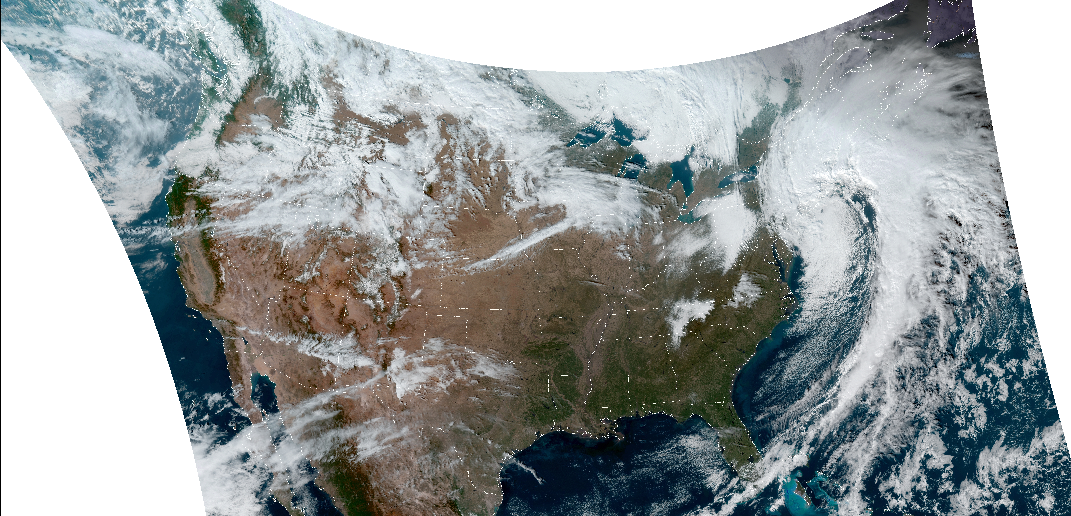

In [9]:
# The goal is a 16:9 jpg file with no matplotlib decoration that is sized w/dpi
# This gets close
w, h = (1920/dpi, 1280/dpi)

matplotlib.rcParams['savefig.pad_inches'] = 0
matplotlib.rcParams['savefig.bbox'] = "tight"
matplotlib.rcParams['savefig.dpi'] = dpi
matplotlib.rcParams['savefig.jpeg_quality'] = 75

fig = matplotlib.pyplot.figure(frameon=False) # Setting size here doesn't work right
fig.set_size_inches(w, h)
ax = matplotlib.pyplot.axes(projection=lcc, frameon=False)
ax.axis('off')
ax.set(xlim=[0, w], ylim=[h, 0], aspect=1) # Square pixels (and they are at nadir)

mpimg = matplotlib.pyplot.imread(sourcefn)
# Create a color tuple for pcolormesh
# Don't use the last column of the RGB array or else the image is not reprojected
rgb = mpimg[:,:-1,:] * (1.0/255.0) # Normalize from RGB(0-255) to (0-1)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # Flatten the array for pcolormesh

# Stack Overflow suggests adding an alpha channel speed up pcolormesh (32-bit alignment?)
# Didn't go faster for me, maybe used more memory
#colorTuple = np.insert(colorTuple, 3, 1.0, axis=1)

# Set the extent of the output raster in lon/lat terms
ax.set_extent(output_extent, crs=cartopy.crs.PlateCarree())
# Create a dummy array w/ data in the proper shape - pcolormesh will use colorTuple for values
dummy_array = np.empty([height, width])
newimg = ax.pcolormesh(lons, lats, dummy_array, color=colorTuple, linewidth=0, transform=platecarree)
newimg.set_array(None) # Without this line the RGB colorTuple is ignored and only dummy is plotted.

matplotlib.pyplot.show()

The center of the US is far less distorted than the edges. The upper left corner is deformed by the off-earth point in the Gulf of Alaska. Most use cases crop this image to a not-too-distorted rectangular area.

In [10]:
#matplotlib.pyplot.savefig(destfn)
matplotlib.pyplot.close(fig) # release memory!